### 1. Importing your libraries and data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [55]:
# Configure API key 

quandl.ApiConfig.api_key = '7misH7_ax9swTisMxyEo'

In [56]:
# Importing the World Bank Data.

data = quandl.get('RATEINF/CPI_USA')

In [57]:
data.head()

,Value
Date,
1913-01-31,9.8
1913-02-28,9.8
1913-03-31,9.8
1913-04-30,9.8
1913-05-31,9.7


In [59]:
data.shape

(1322, 1)

In [60]:
data.columns

Index(['Value'], dtype='object')

In [61]:
type(data)

pandas.core.frame.DataFrame

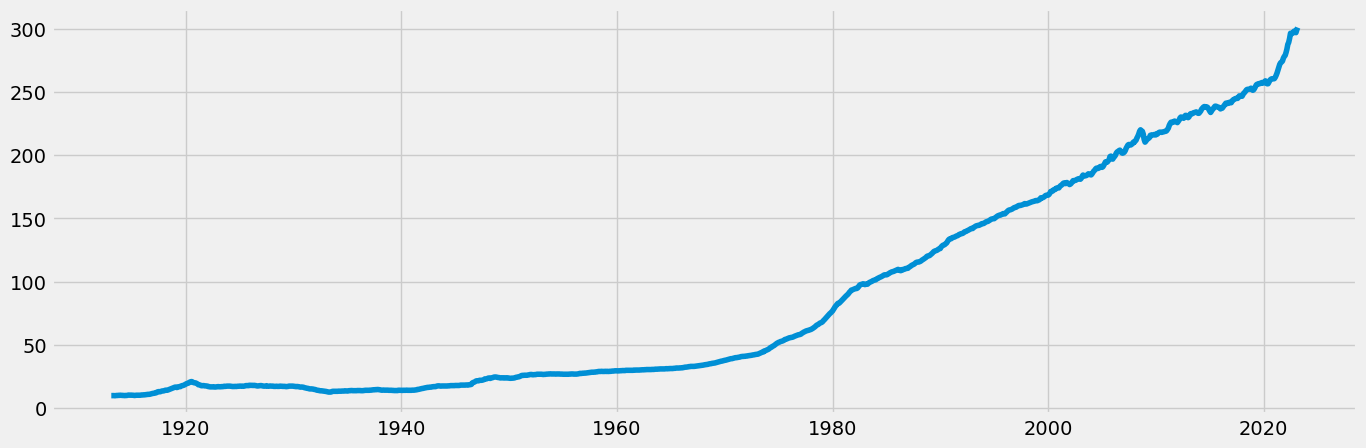

In [62]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data)

### 2. Subsetting, wrangling, and cleaning time-series data

In [63]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [64]:
data_2.head()

,Date,Value
0,1913-01-31,9.8
1,1913-02-28,9.8
2,1913-03-31,9.8
3,1913-04-30,9.8
4,1913-05-31,9.7


In [65]:
data_sub = data_2.loc[(data_2['Date'] >= '1980-01-01') & (data_2['Date'] < '2020-06-01')]

In [66]:
data_sub.shape

(485, 2)

In [67]:
data_sub.head()

,Date,Value
804,1980-01-31,77.8
805,1980-02-29,78.9
806,1980-03-31,80.1
807,1980-04-30,81.0
808,1980-05-31,81.8


In [68]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
1980-01-31,77.8
1980-02-29,78.9
1980-03-31,80.1
1980-04-30,81.0
1980-05-31,81.8


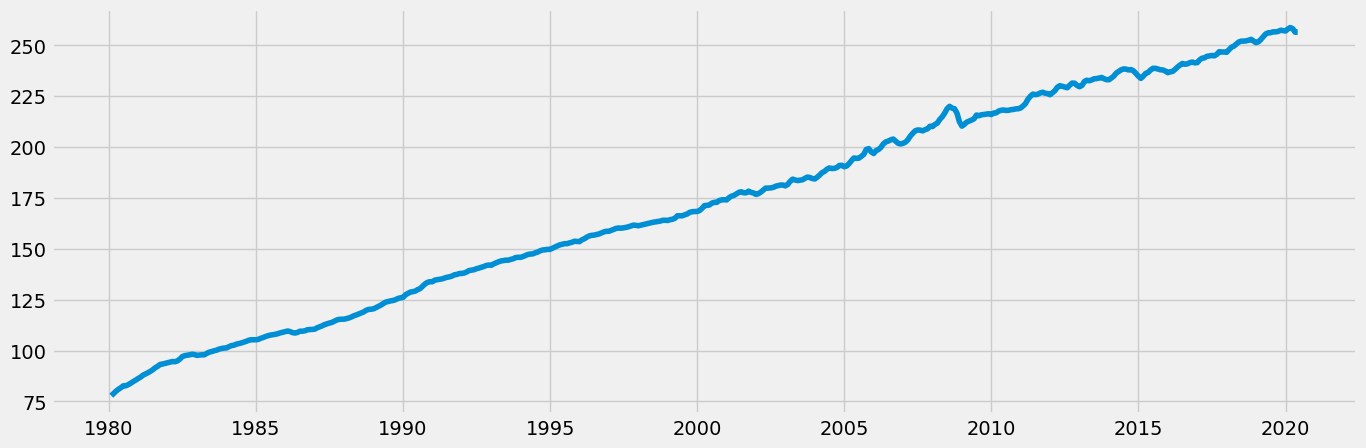

In [69]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [70]:
# Check for missing values

data_sub.isnull().sum() 

Value    0
dtype: int64

In [71]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

29

In [72]:
# Drop duplicates

data_sub = data_sub.drop_duplicates()

In [73]:
# Check duplicates again
dups = data_sub.duplicated()
dups.sum()
# No duplicates

0

In [74]:
data_sub.shape

(456, 1)

In [75]:
data_sub.head()

,Value
datetime,
1980-01-31,77.8
1980-02-29,78.9
1980-03-31,80.1
1980-04-30,81.0
1980-05-31,81.8


### 3. Time-series analysis: decomposition

In [96]:
import statsmodels.api as sm

# convert the date column to a datetime index
data_sub.index = pd.to_datetime(data_sub.index)


In [100]:
# Due to frequency error, I changed to yearly frequency 

data_sub_yearly = data_sub.resample('Y').sum()

In [101]:
decomposition = sm.tsa.seasonal_decompose(data_sub_yearly, model='additive')

In [102]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

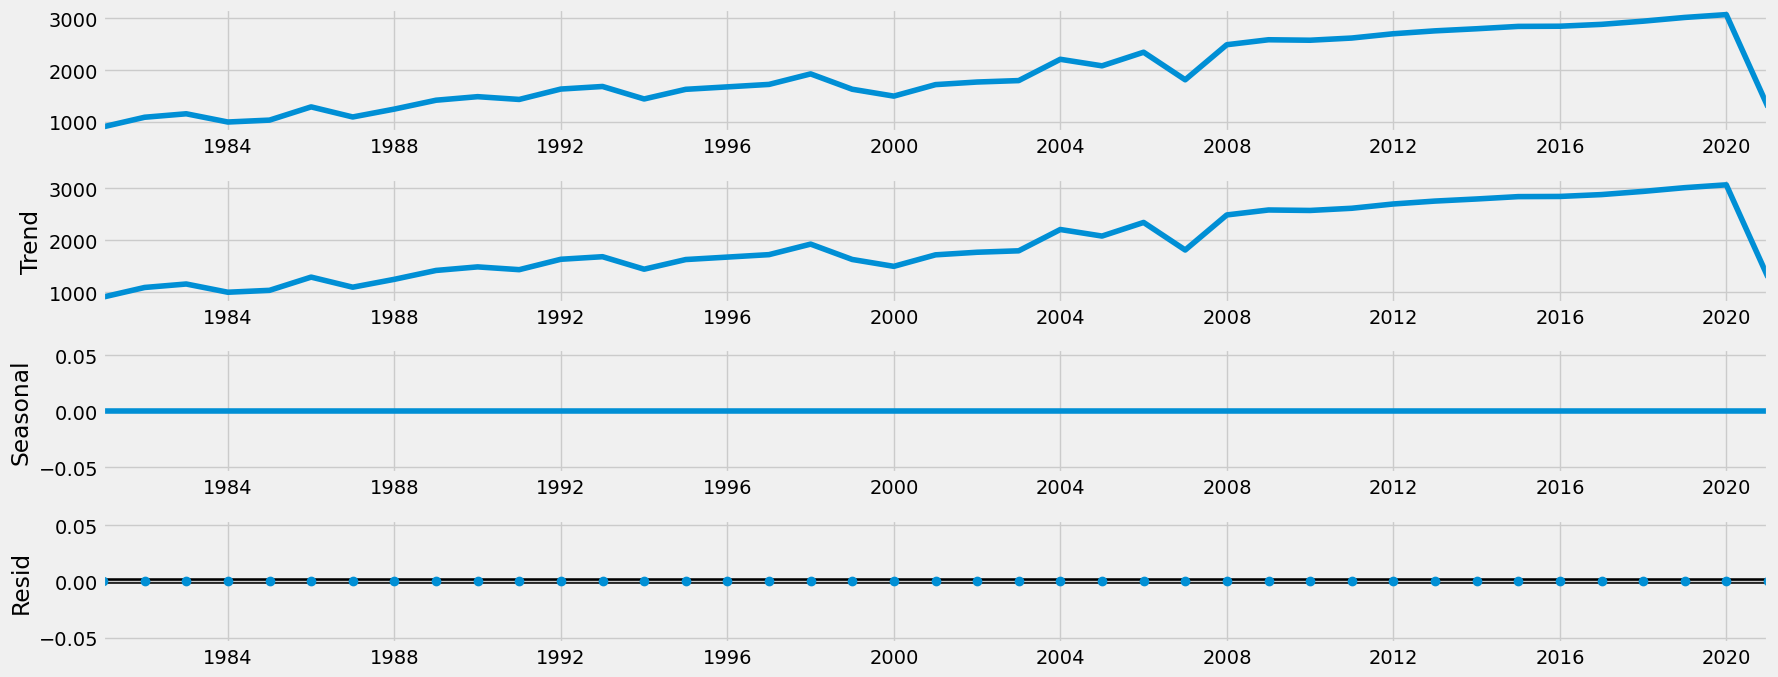

In [103]:
# Plot the separate components

decomposition.plot()
plt.show()

#### There is a general upward trend in inflation values overall between 1980 and 2020.

#### Inflation values drop just before the 2008 financial crisis, and again just after the covid-19 pandemic hit in 2020.

#### No seasonality

#### No unexplained noise

In [104]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -1.120658
p-value                          0.706764
Number of Lags Used             11.000000
Number of Observations Used    444.000000
Critical Value (1%)             -3.445164
Critical Value (5%)             -2.868072
Critical Value (10%)            -2.570249
dtype: float64


#### The test is not significant (p > 0.05).

#### Critical value 5% is much smaller than the test statistic, so we can't reject the null hypothesis. Thus the data is non-stationary.

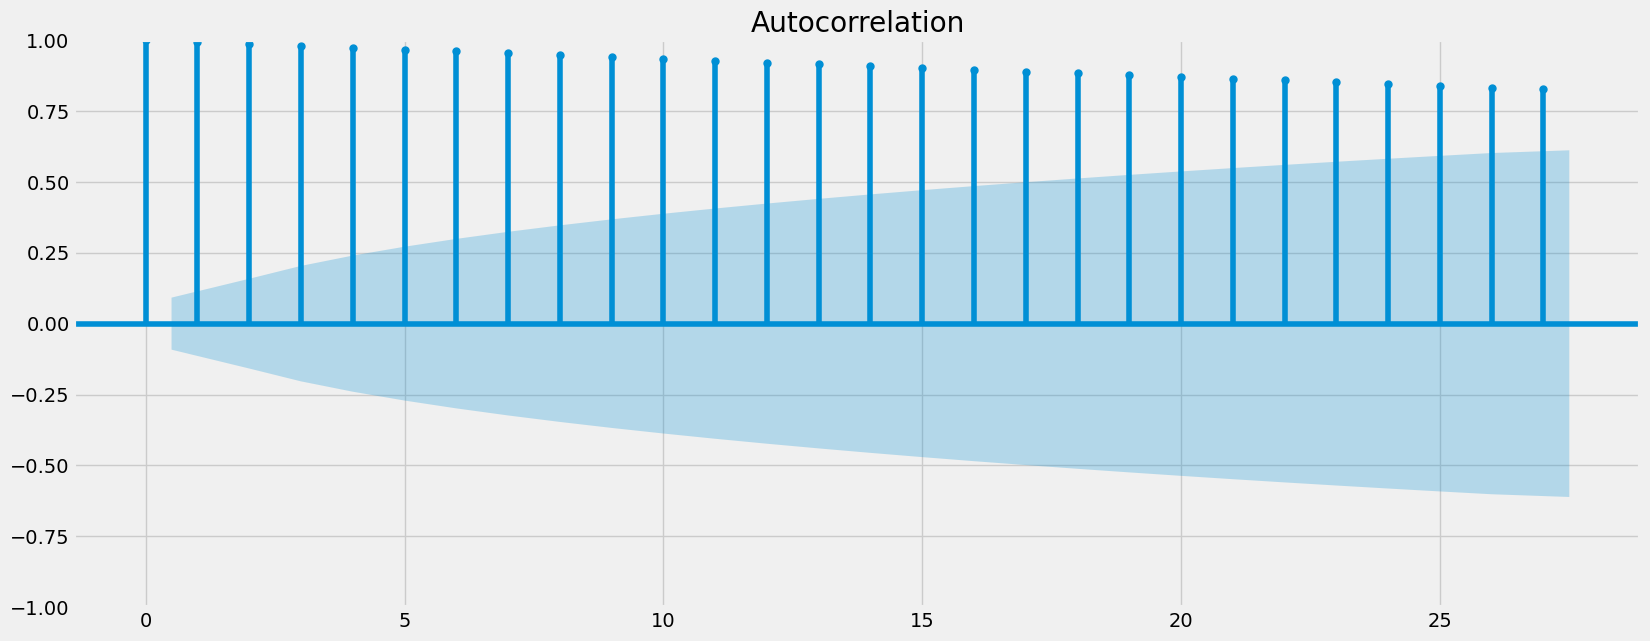

In [105]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

All the lags are correlated to each other, supporting the Dickey-Fuller test that the data is non-stationary.

### 5. Stationarizing 

In [106]:
data_diff = data_sub - data_sub.shift(1) 

In [107]:
data_diff.dropna(inplace = True)

In [108]:
data_diff.head()

,Value
datetime,
1980-02-29,1.1
1980-03-31,1.2
1980-04-30,0.9
1980-05-31,0.8
1980-06-30,0.9


In [109]:
data_diff.columns

Index(['Value'], dtype='object')

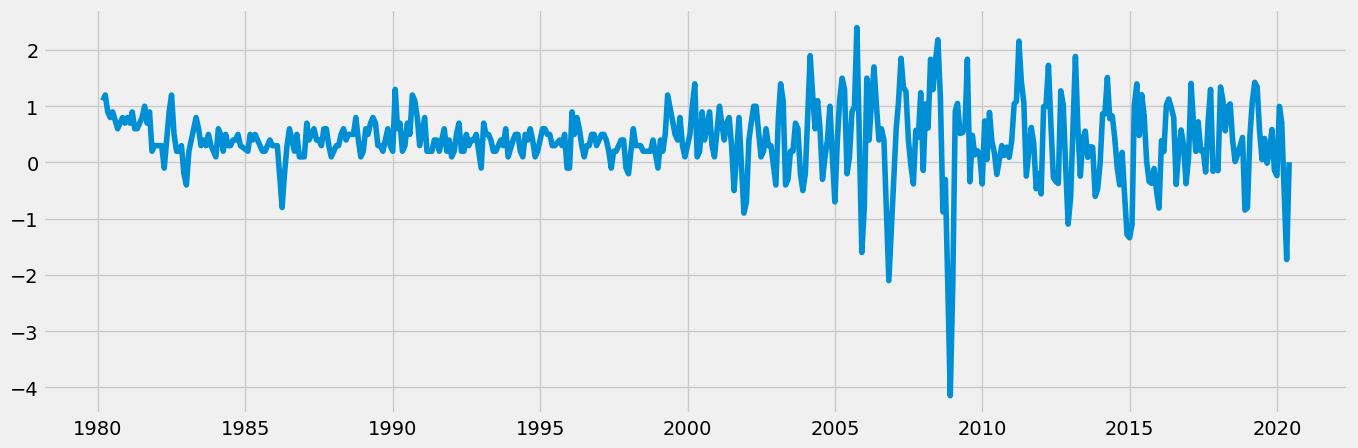

In [110]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [111]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -6.653335e+00
p-value                        5.056059e-09
Number of Lags Used            1.000000e+01
Number of Observations Used    4.440000e+02
Critical Value (1%)           -3.445164e+00
Critical Value (5%)           -2.868072e+00
Critical Value (10%)          -2.570249e+00
dtype: float64


The test statistic is smaller that the critical value at 5% and 10%. However the p value is not significant and we cannot reject the null hypothesis.

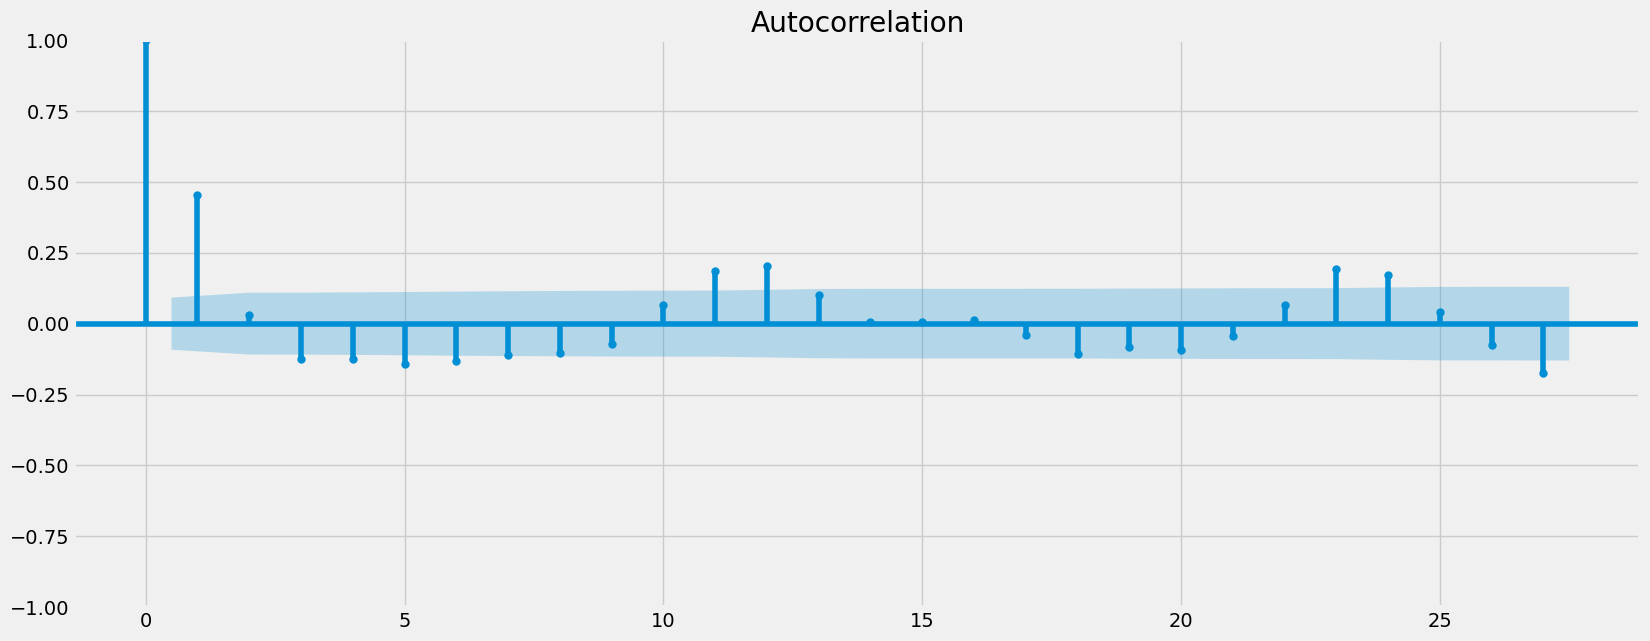

In [112]:
plot_acf(data_diff)
plt.show()

The autocorrelation seems to have improved with multiple values not correlated to each other.